In [1]:
"""Generate thick lines"""
import os
import numpy as np
import imageio
from tqdm import tqdm

from torchvision import datasets
from torch.nn import functional as F

from wavebench import wavebench_dataset_path
from wavebench import utils


mnist_data_path = os.path.join(wavebench_dataset_path, "time_varying/mnist")

if not os.path.exists(mnist_data_path):
  """Save a few MNIST test data as pngs"""
  os.makedirs(mnist_data_path)
  mnist_test_dataset = datasets.MNIST(wavebench_dataset_path, train=False, download=True)

  for k in tqdm(range(num_data)):
    f = np.array(mnist_test_dataset.data[k])
    imageio.imwrite(
        os.path.join(f'{mnist_data_path}/{k}.png'), f)#, (f * 255).astype(np.uint8))


In [3]:
# %%
import os
import ml_collections
import numpy as np
import cv2
import matlab.engine # the matlab engine for python
import jax

import matplotlib.pyplot as plt
from wavebench.generate_data.time_varying.generate_data_rtc import generate_rtc
from wavebench import wavebench_dataset_path
from wavebench.utils import absolute_file_paths
from wavebench import wavebench_path
from wavebench.plot_utils import plot_images, remove_frame

# %%
# thick_lines_data_path = os.path.join(
#     wavebench_dataset_path, "time_varying/thick_lines")

config = ml_collections
config.save_data = False
# config.medium_type = 'gaussian_random_field' #'gaussian_lens'
config.medium_type = 'gaussian_lens'
config.device_id = 0


config.domain_sidelen = 128
config.domain_dx = 8
# the above seetings give a domain of 1024 km x 1024 km

config.medium_source_loc = (50, 55)
config.medium_density = 2650
config.pml_size = 2

#  define the properties of the propagation medium
min_wavespeed = 1400 # [m/s]
max_wavespeed = 4000 # [m/s]
point_mass_strength = -31000

if config.medium_type == 'gaussian_lens':
  z = np.ones((config.domain_sidelen,config.domain_sidelen))
  z[config.medium_source_loc] = point_mass_strength
  medium_sound_speed = cv2.GaussianBlur(
      z,
      ksize=(0, 0),
      sigmaX=50,
      borderType=cv2.BORDER_REPLICATE)
elif config.medium_type == 'gaussian_random_field':
  medium_sound_speed = np.fromfile(
    os.path.join(
      wavebench_dataset_path, "time_varying/wavespeed/cp_128x128_00001.H@"),
    dtype=np.float32).reshape(128, 128)

  if config.domain_sidelen != 128:
    medium_sound_speed = jax.image.resize(
        medium_sound_speed,
        (config.domain_sidelen, config.domain_sidelen),
        'bicubic')
else:
  raise NotImplementedError

medium_sound_speed -= medium_sound_speed.min()
medium_sound_speed /= medium_sound_speed.max()

config.medium_sound_speed = medium_sound_speed*(
max_wavespeed - min_wavespeed) + min_wavespeed



Save data? False


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Running k-Wave simulation...
  start time: 14-May-2023 09:50:31
  reference sound speed: 4000m/s
  dt: 600us, t_end: 200.4ms, time steps: 335
  input grid size: 128 by 128 grid points (1.024 by 1.024km)
  maximum supported frequency: 87.5Hz
  smoothing p0 distribution...
  precomputation completed in 0.32884s
  starting time loop...
  estimated simulation time 0.90088s...
  simulation completed in 0.61009s
  total computation time 0.94412s

sensor_data = 

  struct with fields:

    p_final: [128x128 double]

2.714598646552581e-06


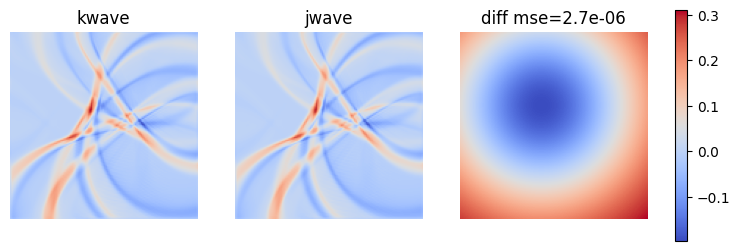

In [19]:
# only a single example is generated

# data_path = mnist_data_path
data_path = os.path.join(wavebench_dataset_path, "time_varying/thick_lines")

config.source_list = sorted(absolute_file_paths(data_path))[:1]#[82:83]
initial_pressure_dataset, final_pressure_dataset = generate_rtc(config)
jwave_final_pressure = final_pressure_dataset[0]

# %%

eng = matlab.engine.start_matlab()
eng.cd(str(os.path.join(wavebench_path, "wavebench/generate_data/test")))

# MATLAB expects the input arguments to be of data type double
kwave_final_pressure = eng.compute_rtc_final(
  np.double(config.medium_sound_speed),
  np.double(config.medium_density),
  np.double(config.domain_dx),
  initial_pressure_dataset[0],
  np.double(config.pml_size),
)
kwave_final_pressure = np.array(kwave_final_pressure)


# %%
mse = np.mean( (kwave_final_pressure - jwave_final_pressure)**2 )
np.testing.assert_array_less(mse, 1e-4)
print(mse)

# %%

fig, axes = plot_images(
  [kwave_final_pressure,
   jwave_final_pressure,
   np.abs(jwave_final_pressure - kwave_final_pressure)],
  cbar='one',
  # vrange='individual',
  fig_size=(9, 3),
  cmap='coolwarm')

axes[0].set_title('kwave')
axes[1].set_title('jwave')
axes[2].set_title(f'diff mse={mse:.2}')

[remove_frame(ax) for ax in axes.flatten()]

# %%

plt.imshow(config.medium_sound_speed, cmap='coolwarm')

# %%


In [20]:
kwave_final_pressure.min()

-0.19735702858046972

In [7]:
kwave_final_pressure.min()

-0.3715197666325148

In [16]:
sorted(absolute_file_paths(os.path.join(wavebench_dataset_path, "time_varying/thick_lines")))[:1]

['/home/liu0003/Desktop/projects/wavebench/wavebench_dataset/time_varying/thick_lines/0.png']

In [21]:
from jwave.utils import load_image_to_numpy

initial_pressure = load_image_to_numpy(
    config.source_list[0],
    # sorted(absolute_file_paths(
    #     os.path.join(wavebench_dataset_path, "time_varying/thick_lines")))[:2],
    image_size=(config.domain_sidelen, config.domain_sidelen))/255



In [22]:
initial_pressure.max()

0.9843137

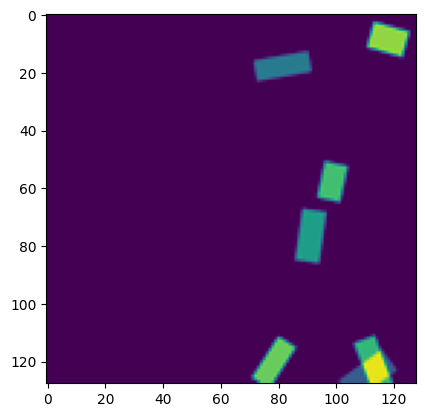

In [23]:
plt.imshow(initial_pressure)